<a href="https://colab.research.google.com/github/moh2236945/Natural-language-processing/blob/master/Apply%20features%20extrating%20and%20text%20normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import numpy as np
%matplotlib inline

In [2]:
train=pd.read_csv('/content/train_E6oV3lV.csv')
test=pd.read_csv('/content/test_tweets_anuFYb8.csv')
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


data has 3 columns id, label, and tweet. ***label*** is the binary target variable and ***tweet*** contains the tweets that we will clean and preprocess.

In [9]:
#Removing @ to do this we sure to combine train and test together fires
combi=train.append(test,ignore_index=True)
combi.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(49159, 3)

In [0]:
def remove_pattern(input_text,pattern):
    r=re.findall(pattern,input_text)
    for i in r:
        input_text=re.sub(i,'',input_text)

    return input_text

create a new column tidy_tweet, 
it contain the cleaned and processed tweets. **Note** that we have passed “@[\w]*” as the pattern to the remove_pattern function. It is actually a regular expression which will pick any word starting with ‘@’.

In [0]:
combi['tidy_tweet']=np.vectorize(remove_pattern)(combi['tweet'],"@[\w]*")

In [14]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [15]:
#removing Punction,Number&Special chars
combi['tidy_tweet']=combi['tidy_tweet'].str.replace('[^a-zA-Z#]', "")
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,whenafatherisdysfunctionalandissoselfishhedrag...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanksfor#lyftcrediticantusecausetheydontoffer...
2,3,0.0,bihday your majesty,bihdayyourmajesty
3,4,0.0,#model i love u take with u all the time in ...,#modeliloveutakewithuallthetimeinur
4,5,0.0,factsguide: society now #motivation,factsguidesocietynow#motivation


Removing Short Words

In [0]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))


Text Normalization
Steps:
Tokenization > Normalization

In [18]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing
tokenized_tweet.head()


0    [whenafatherisdysfunctionalandissoselfishhedra...
1    [thanksfor#lyftcrediticantusecausetheydontoffe...
2                                  [bihdayyourmajesty]
3                [#modeliloveutakewithuallthetimeinur]
4                    [factsguidesocietynow#motivation]
Name: tidy_tweet, dtype: object

In [0]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [0]:
#stitch these tokens back together.
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
combi['tidy_tweet'] = tokenized_tweet

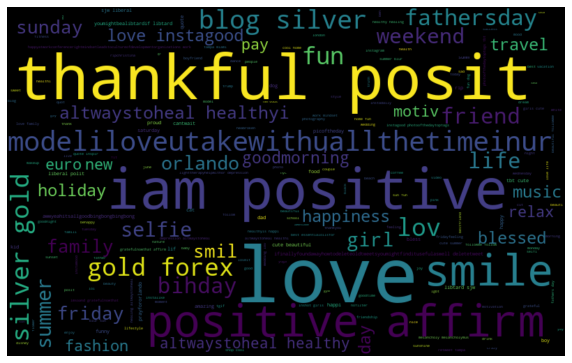

In [21]:
#Understanding the common words used in the tweets: WordCloud
#A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

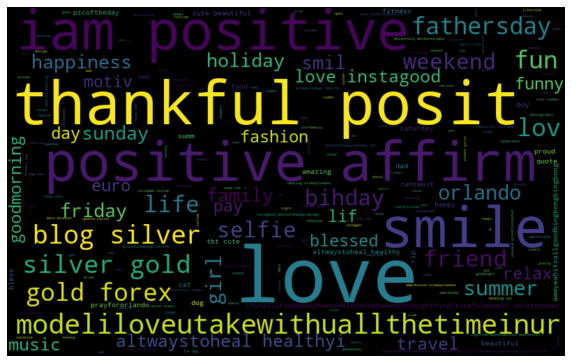

In [22]:
#Words in non racist/sexist tweets
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [0]:
# Understanding the impact of Hashtags on tweets sentiment
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [0]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

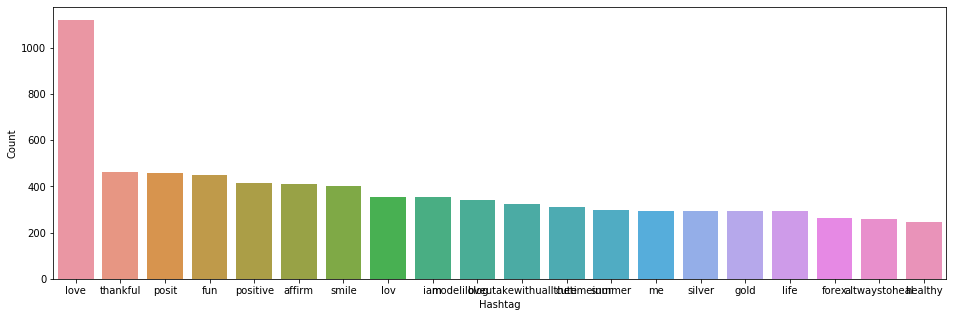

In [25]:
#Non-Racist/Sexist Tweets
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [0]:
#extract Features from Cleaned tweets
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

In [29]:
#Bag-of-Words Features
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(49159, 1000)

In [30]:
#TF-IDF Features
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(49159, 1000)

In [31]:
#Word Embedding
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

(176265, 983080)

In [0]:
#Preparing Vectors for Tweets

def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [37]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


(49159, 200)

In [0]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output
labeled_tweets = add_label(tokenized_tweet) # label all the tweets
labeled_tweets[:6]
